In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

# Import TensorFlow and Keras modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM

# Import pre-trained models from TensorFlow Keras applications
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB6, InceptionV3, ResNet50

# Additional callbacks and optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam

# Example of defining a simple model (optional)
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100, 1)))  # Adjust input_shape as needed
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))  # Adjust output layer as needed

# Compile the model (optional)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary (optional)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 98, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 32)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 25025 (97.75 KB)
Trainable params: 25025 (97.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [2]:
df_dk=pd.read_csv('Keylogger_Detection.csv')
df_dk.head(5)

C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (48,56) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,0,10.42.0.211-52.6.25.230-34451-443-6,10.42.0.211,34451.0,52.6.25.230,443.0,6.0,04/08/2017 05:12:36,12140931.0,9.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,1,172.217.3.99-10.42.0.151-443-53892-6,10.42.0.151,53892.0,172.217.3.99,443.0,6.0,04/08/2017 07:55:51,418882.0,102.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,2,172.217.3.98-10.42.0.151-443-50750-6,172.217.3.98,443.0,10.42.0.151,50750.0,6.0,04/08/2017 08:48:19,45.0,2.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,3,10.42.0.211-10.42.0.1-23025-53-17,10.42.0.211,23025.0,10.42.0.1,53.0,17.0,04/08/2017 05:54:10,541699.0,1.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,4,10.42.0.211-123.129.244.226-52602-443-6,10.42.0.211,52602.0,123.129.244.226,443.0,6.0,04/08/2017 08:44:25,7310795.0,3.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [3]:
df_dk.dtypes

Unnamed: 0           int64
Flow ID             object
 Source IP          object
 Source Port       float64
 Destination IP     object
                    ...   
Idle Mean          float64
 Idle Std          float64
 Idle Max          float64
 Idle Min          float64
Class               object
Length: 86, dtype: object

In [4]:
Class_df = df_dk["Class"]
df_num = df_dk.select_dtypes(include=[np.number])
df_num = df_num.join(Class_df)

In [5]:
df_num.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
print(df_num.isna().sum().sum())
df_num=df_num.dropna()

879


In [7]:
df_num["label"]=df_num["Class"]
df_num.loc[df_num.label == "Benign", 'label'] = 0
df_num.loc[df_num.label == "Keylogger", 'label'] = 1
df_num.drop('Class', axis=1, inplace=True)
df_num.sample(5)

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
307882,60744.0,53.0,17.0,51221.0,1.0,1.0,30.0,75.0,30.0,30.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
404260,47104.0,80.0,6.0,5066630.0,2.0,2.0,0.0,0.0,0.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
86495,36612.0,443.0,6.0,43.0,1.0,1.0,31.0,0.0,31.0,31.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
335445,53356.0,80.0,6.0,17748971.0,3.0,1.0,0.0,0.0,0.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
119274,4164.0,53.0,17.0,30657.0,1.0,1.0,36.0,218.0,36.0,36.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [8]:
df_num=df_num.sample(n=200000)

In [9]:
df_num.groupby('label').size()

label
0    118233
1     81767
dtype: int64

In [10]:
for col in (df_num.iloc[:,:-1].columns):
    if(df_num[col].min()==df_num[col].max()):
            df_num.drop(col, axis=1, inplace=True)

In [11]:
# Normalization OR Standardization
def standardize(df,col):
    #df[col]= (df[col]-df[col].mean())/(df[col].std()) # Standardization
    df[col]= 255*(df[col]-df[col].min())/(df[col].max()-df[col].min()) #Normalization

for i in (df_num.iloc[:,:-1].columns):
    standardize (df_num,i)

df_num.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
43321,129.963148,0.206563,255.0,2.256272,0.000000,0.017123,0.001067,0.000937,5.763699,5.763699,...,254.999989,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0
484954,231.458066,1.726554,90.0,0.467230,0.357198,0.154110,0.032875,0.062263,118.417808,0.000000,...,254.999989,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1
31363,1.723814,171.860366,90.0,0.016501,0.000000,0.017123,0.000000,0.000000,0.000000,0.000000,...,254.999989,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1
406070,178.319447,1.726554,90.0,0.034114,0.119066,0.000000,0.001972,0.000000,6.636986,0.000000,...,254.999989,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0
485462,147.960081,1.726554,255.0,32.223091,0.476265,0.222603,0.156068,0.036760,235.787671,4.017123,...,254.999989,1.233136,0.0,0.728683,1.233136,31.679916,0.0,31.679916,31.679916,0


In [12]:
for i in range(957):
    col="A"+str(i)
    df_num[col]=0

df_num.shape


(200000, 1025)

In [13]:
target=['label']
features = [c for c in df_num.columns if c!="label"]

<class 'numpy.ndarray'>


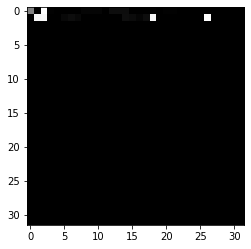

In [14]:
row_1=df_num[features].iloc[0].to_numpy()
row_1.shape
row_2=row_1.reshape(32, 32)
row_2=row_2.astype(int)
print(type(row_2))
from matplotlib import pyplot as plt
plt.imshow(row_2,cmap='gray')
plt.show()

In [15]:
X = df_num[features].values # Features
y = df_num[target].values # Target

X=X.astype(np.float32)
y=y.astype(np.float32)

X.shape,y.shape,

((200000, 1024), (200000, 1))

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [17]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((160000, 1024), (40000, 1024), (160000, 1), (40000, 1))

In [18]:
X_train_cnn = np.reshape(X_train, (X_train.shape[0], 32,32,1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], 32,32,1))
print(X_train_cnn.shape)
print(X_test_cnn.shape)


(160000, 32, 32, 1)
(40000, 32, 32, 1)


In [19]:
learning_rate=0.0001
batch_size=1024
epochs = 50

model_save = ModelCheckpoint('./Keylogging.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.0001, 
                           patience = 10, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.75, 
                              patience = 10, min_delta = 0.0001, 
                              mode = 'min', verbose = 1)

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

def create_model():
    # Define input layer for grayscale images
    inputs = layers.Input(shape=(32, 32, 1))  # Grayscale input

    # Convert grayscale to RGB if necessary
    grayscale_to_rgb = layers.Conv2D(3, kernel_size=(1, 1), activation='linear', padding='same')(inputs)

    # Create EfficientNetB0 model without the top classification layer
    efficientnet_model = EfficientNetB0(include_top=False, weights='imagenet', pooling='avg')

    # Pass the RGB converted input to EfficientNetB0
    x = efficientnet_model(grayscale_to_rgb)

    # Flatten the output from EfficientNetB0
    x = layers.Flatten()(x)

    # Output layer for binary classification
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model with Adam optimizer and binary crossentropy loss
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Create and summarize the model
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 3)         6         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4050858 (15.45 MB)
Trainable params: 4008835 (15.29 MB)
Non-trainable params: 42023 (164.16 KB)
_________________

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist  # Or any dataset suitable for CNN

# Load the data (for example, MNIST dataset)
(X, y), (X_val, y_val) = mnist.load_data()  # Loads images and labels for training and validation

# Preprocess the data to have the correct shape and range
X = X.reshape(-1, 28, 28, 1).astype('float32') / 255  # Reshape and normalize
X_val = X_val.reshape(-1, 28, 28, 1).astype('float32') / 255

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now you can use X_train, y_train, X_test, y_test in your CNN model


11490434/11490434 [==============================] - 3s 0us/step


In [ ]:
####
history = model.fit(X_train_cnn,
                    y_train,
                    batch_size=batch_size,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(X_test_cnn,y_test),
                    callbacks = [model_save, early_stop, reduce_lr],)

# 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define some parameters
input_shape = (28, 28, 1)  # Example shape for grayscale 28x28 images (adjust as needed)
num_classes = 10  # Number of output classes (for example, digits 0-9 for MNIST)
batch_size = 32
epochs = 10

# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
model_save = ModelCheckpoint('best_model.h5', save_best_only=True)
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=2, min_lr=0.0001)

# Train the model
history = model.fit(X_train,  # Replace with X_train_cnn if modified in preprocessing
                    y_train,
                    batch_size=batch_size,
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),  # Replace with X_test_cnn if modified
                    callbacks=[model_save, early_stop, reduce_lr])

# The model training history is stored in the 'history' variable


In [6]:
from sklearn import metrics

# Ensure X_test and y_test are properly defined
y_pred = model.predict(X_test, batch_size=512)  # Replace X_test with X_test_cnn if needed

# If y_test is categorical, convert y_pred and y_test to a binary format or one-vs-rest structure
# For multi-class AUC, use average="macro" or "weighted"
if y_pred.shape[1] > 1:  # Multi-class case
    y_test_bin = tf.keras.utils.to_categorical(y_test, num_classes=y_pred.shape[1])
    AUC = metrics.roc_auc_score(y_test_bin, y_pred, average="macro", multi_class="ovr")
else:  # Binary case
    AUC = metrics.roc_auc_score(y_test, y_pred)

print("AUC: {:.3f}".format(AUC))


24/24 [==============================] - 1s 53ms/step
AUC: 1.000


In [10]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

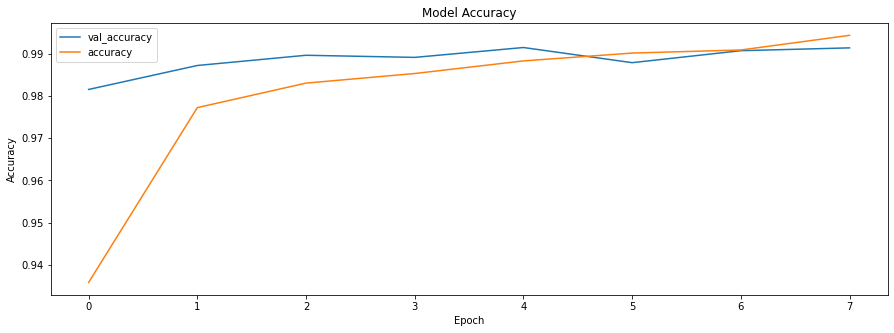

In [17]:
import matplotlib.pyplot as plt

# Plot accuracy over epochs for training and validation as an alternative to AUC
plt.figure(figsize=(15, 5))
plt.plot(range(history.epoch[-1] + 1), history.history['val_accuracy'], label='val_accuracy')
plt.plot(range(history.epoch[-1] + 1), history.history['accuracy'], label='accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


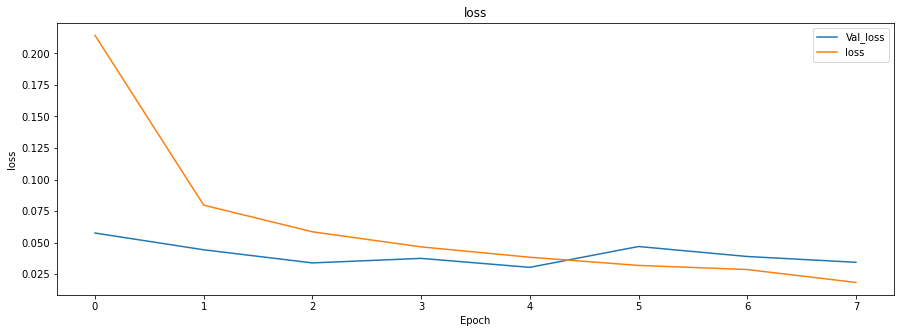

In [18]:


plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='loss')
plt.title('loss'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

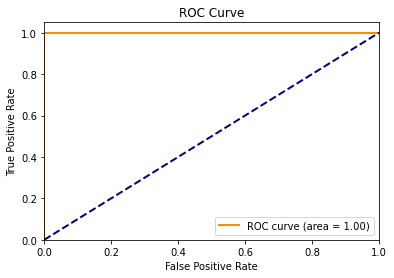

In [3]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def generate_results(y_test, y_score):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Example data for testing
# y_test is the true labels for the test set
# y_pred are the predicted probabilities or predicted labels
# Replace these with your actual data and model predictions
y_test = [0, 1, 0, 1, 0, 1]  # Example true labels (binary classification)
y_pred = [0.1, 0.8, 0.4, 0.9, 0.2, 0.85]  # Example predicted probabilities (should be continuous values)

# Call the function with your test data and predictions
generate_results(y_test, y_pred)
